#  Proteomics-Based Comparative Mapping of the Secretomes of Human Brown and White Adipocytes Reveals EPDR1 as a Novel Batokine

Adipokines secreted from white adipose tissue play a role in metabolic crosstalk and homeostasis, whereas the brown adipose secretome is less explored. We performed high-sensitivity mass-spec- trometry-based proteomics on the cell media of human adipocytes derived from the supraclavicular brown ad- ipose and from the subcutaneous white adipose de- pots of adult humans. We identified 471 potentially secreted proteins covering interesting categories such as hormones, growth factors, extracellular matrix
proteins, and proteins of the complement system, which were differentially regulated between brown and white adipocytes. A total of 101 proteins were exclusively quantified in brown adipocytes, and among these was ependymin-related protein 1 (EPDR1). EPDR1 was detected in human plasma, and functional studies suggested a role for EPDR1 in thermogenic determination during adipogenesis. In conclusion, we report substantial differences between the secretomes of brown and white human adipocytes and identify novel candidate batokines that can be important regu- lators of human metabolism. REF: https://www.cell.com/cell-metabolism/fulltext/S1550-4131(19)30556-X

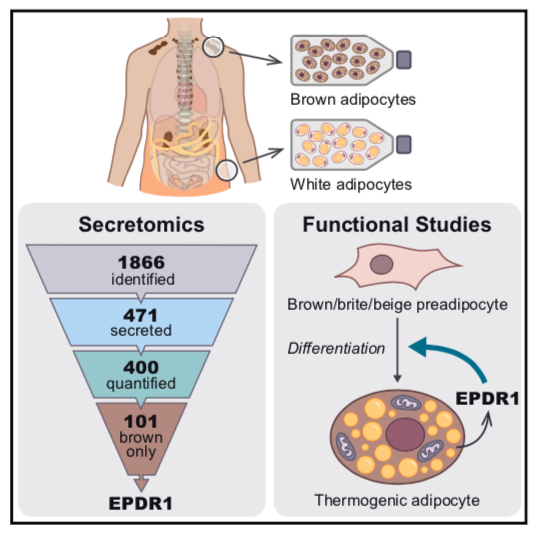




In [1]:
import os
import re
import pandas as pd
import numpy as np

import ckg.ckg_utils as ckg_utils
from ckg.graphdb_builder import builder_utils, mapping
from ckg.graphdb_builder.experiments.parsers import proteomicsParser
from ckg.graphdb_connector import connector

from ckg.analytics_core.analytics import analytics
from ckg.analytics_core.viz import viz

from ckg.report_manager import knowledge

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
%matplotlib inline
init_notebook_mode(connected=True)

C:\Users\sande\.conda\envs\ckgenv\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\sande\.conda\envs\ckgenv\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


WGCNA functions will not work. Module Rpy2 not installed.
R functions will not work. Module Rpy2 not installed.


In [2]:
analysis_dir = '../../../../data/tmp/Deshmukh2019'
ckg_utils.checkDirectory(analysis_dir)

pxd_id = 'PXD008541'
file_name='SearchEngineResults_secretome.zip.rar'

## Download Data from PRIDE

We can use functionality in graphdb_builder to directly download data files from EBI's PRIDE database (https://www.ebi.ac.uk/pride/). For that you you just need to specify the PRIDE identifier for the project (PXD...) and the name of the file to download. In this case, the project identifier is PXD008541 and the file we will use is SearchEngineResults_secretome.zip.rar, a RAR compressed file.

In [3]:
builder_utils.download_PRIDE_data(pxd_id=pxd_id, 
                                  file_name=file_name, 
                                  to=analysis_dir)

'publicationDate'


{'status': 'INTERNAL_SERVER_ERROR',
 'code': 500,
 'message': 'Internal Server Error: Could not open JPA EntityManager for transaction; nested exception is javax.persistence.QueryTimeoutException: Could not open connection',
 'developerMessage': 'Please report to pride-support@ebi.ac.uk',
 'moreInfoUrl': None,
 'throwable': None}

## Read Data In

### Decompress File

In [4]:
builder_utils.unrar(filepath=os.path.join(analysis_dir, file_name), to=analysis_dir)

Error: ../../../../data/tmp/Deshmukh2019\SearchEngineResults_secretome.zip.rar. Could not unrar file Unrar not installed? (rarfile.UNRAR_TOOL='unrar')


The list of files within the compressed folder can be listed using the listDirectoryFiles functionality in gaphdb_builder.

In [5]:
builder_utils.listDirectoryFiles(analysis_dir)

['anova_results.tsv',
 'BAT_woNE_vs_WAT_woNE_volcano_plot.svg',
 'missing_values_per_sample.svg',
 'original_data_boxplot.svg',
 'original_data_distplot.svg',
 'original_data_parallel_plot_upregulated_proteins.svg',
 'pca.svg',
 'processed_data_boxplot.svg',
 'processed_data_distplot.svg',
 'processed_data_matrix.tsv',
 'processed_data_parallel_plot_upregulated_proteins.svg',
 'SearchEngineResults_secretome.zip.rar',
 'secreted_processed_data.tsv',
 'secretome.tsv']

We use the proteinGroups file that contains the proteomics data processed using MaxQuant software.

In [6]:
proteinGroups_file = os.path.join(os.path.join(analysis_dir, "SearchEngineResults_secretome"), 'proteinGroups.txt')

### Parse Contents

CKG has parsers for MaxQuant and Spectronaut output files. The default configuration needed to parse these files needs to be updated with the name of the columns containing the protein quantifications for each sample. Also, the default configuration can be adapted to the experiment by selected specific filters or removing non-used columns. For example, in this study the output file did not have columns: Score, Q-value, so we removed them from the configuration and the column 'Potential contaminant' was renamed to 'Contaminant' so we changed the name in the filters.

In [7]:
#d = pd.read_csv(proteinGroups_file, sep='\t')
#d.columns.tolist()

In [8]:
columns = ['LFQ intensity BAT_NE1',
           'LFQ intensity BAT_NE2',
           'LFQ intensity BAT_NE3',
           'LFQ intensity BAT_NE4',
           'LFQ intensity BAT_NE5',
           'LFQ intensity BAT_woNE1',
           'LFQ intensity BAT_woNE2',
           'LFQ intensity BAT_woNE3',
           'LFQ intensity BAT_woNE4',
           'LFQ intensity BAT_woNE5',
           'LFQ intensity WAT_NE1',
           'LFQ intensity WAT_NE2',
           'LFQ intensity WAT_NE3',
           'LFQ intensity WAT_NE4',
           'LFQ intensity WAT_NE5',
           'LFQ intensity WAT_woNE1',
           'LFQ intensity WAT_woNE2',
           'LFQ intensity WAT_woNE3',
           'LFQ intensity WAT_woNE4',
           'LFQ intensity WAT_woNE5', 
           'Contaminant']

In [9]:
configuration = proteomicsParser.update_configuration(data_type='proteins', 
                                                      processing_tool='maxquant', 
                                                      value_col='LFQ intensity', 
                                                      columns=columns,
                                                      regex=r'(\w+_\w+\d+)',
                                                      drop_cols=['Score', 'Q-value', 'Potential contaminant'],
                                                      filters=['Reverse', 'Only identified by site', 'Contaminant'])

In [10]:
configuration

{'columns': ['Majority protein IDs',
  'Razor + unique peptides',
  'id',
  'LFQ intensity AS\\d+_?-?\\d*',
  'Intensity AS\\d+_?-?\\d*',
  'Reverse',
  'Only identified by site',
  'is_razor',
  'LFQ intensity BAT_NE1',
  'LFQ intensity BAT_NE2',
  'LFQ intensity BAT_NE3',
  'LFQ intensity BAT_NE4',
  'LFQ intensity BAT_NE5',
  'LFQ intensity BAT_woNE1',
  'LFQ intensity BAT_woNE2',
  'LFQ intensity BAT_woNE3',
  'LFQ intensity BAT_woNE4',
  'LFQ intensity BAT_woNE5',
  'LFQ intensity WAT_NE1',
  'LFQ intensity WAT_NE2',
  'LFQ intensity WAT_NE3',
  'LFQ intensity WAT_NE4',
  'LFQ intensity WAT_NE5',
  'LFQ intensity WAT_woNE1',
  'LFQ intensity WAT_woNE2',
  'LFQ intensity WAT_woNE3',
  'LFQ intensity WAT_woNE4',
  'LFQ intensity WAT_woNE5',
  'Contaminant'],
 'generated_columns': ['is_razor'],
 'filters': ['Reverse', 'Only identified by site', 'Contaminant'],
 'proteinCol': 'Majority protein IDs',
 'contaminant_tag': 'CON__',
 'valueCol': 'LFQ intensity',
 'groupCol': 'id',
 'indexC

When we parse the data, we obtain a matrix in an edge list following CKG's graph format: sample, protein, realtionship_type, value, protein_group_id, is_razor

In [11]:
data = proteomicsParser.parser_from_file(proteinGroups_file, configuration=configuration, data_type='proteins')[('proteins', 'w')]

In [12]:
data.head()

START_ID  END_ID                    TYPE      value  id  is_razor
0  WAT_woNE5  A0AVL1  HAS_QUANTIFIED_PROTEIN  20.109423   0     False
1    BAT_NE5  A1A441  HAS_QUANTIFIED_PROTEIN  22.986122   1     False
2  BAT_woNE3  A1A441  HAS_QUANTIFIED_PROTEIN  22.753054   1     False
3  BAT_woNE5  A1A441  HAS_QUANTIFIED_PROTEIN  22.475955   1     False
4    BAT_NE3  A1A441  HAS_QUANTIFIED_PROTEIN  23.317552   1     False

In [13]:
data.columns = ['sample', 'identifier', 'relationship', 'LFQ intensity', 'id', 'is_razor']

In [14]:
data.head()

sample identifier            relationship  LFQ intensity  id  is_razor
0  WAT_woNE5     A0AVL1  HAS_QUANTIFIED_PROTEIN      20.109423   0     False
1    BAT_NE5     A1A441  HAS_QUANTIFIED_PROTEIN      22.986122   1     False
2  BAT_woNE3     A1A441  HAS_QUANTIFIED_PROTEIN      22.753054   1     False
3  BAT_woNE5     A1A441  HAS_QUANTIFIED_PROTEIN      22.475955   1     False
4    BAT_NE3     A1A441  HAS_QUANTIFIED_PROTEIN      23.317552   1     False

In [15]:
data.shape

(57470, 6)

In [16]:
data = data[data.is_razor]

In [17]:
data.shape

(17489, 6)

We can use the sample names to extract the group information: BAT_NE, WAT_NE, BAT_woNE, WAT_woNE

With this last column, we obtain the **original dataframe** used as starting point in CKG' analysis pipelines.

In [18]:
data['group'] = data['sample'].apply(lambda x: re.sub('\d', '', x))

In [19]:
data.head()

sample identifier            relationship  LFQ intensity  id  \
7      BAT_NE4     A1L4H1  HAS_QUANTIFIED_PROTEIN      21.686542   2   
134    WAT_NE4     A6NCN2  HAS_QUANTIFIED_PROTEIN      27.843440  10   
135  BAT_woNE2     A6NDG6  HAS_QUANTIFIED_PROTEIN      23.446827  11   
136    BAT_NE5     A6NDG6  HAS_QUANTIFIED_PROTEIN      23.047168  11   
137  BAT_woNE3     A6NDG6  HAS_QUANTIFIED_PROTEIN      23.307164  11   

     is_razor     group  
7        True    BAT_NE  
134      True    WAT_NE  
135      True  BAT_woNE  
136      True    BAT_NE  
137      True  BAT_woNE

In [20]:
original = data[['group', 'sample', 'identifier', 'LFQ intensity']]

In [21]:
df = analytics.transform_proteomics_edgelist(original,
                                           index_cols=['group', 'sample'], 
                                           drop_cols=['sample'], 
                                           group='group', 
                                           identifier='identifier', 
                                           extra_identifier=None, 
                                           value_col='LFQ intensity')

In [22]:
df.shape

(20, 1868)

In [23]:
df.describe()

identifier     A1L4H1    A6NCN2     A6NDG6     A8K2U0     B3EWG6     B3KW70  \
count        1.000000   1.00000   8.000000   5.000000   1.000000  20.000000   
mean        21.686542  27.84344  23.357560  21.966594  22.579298  28.716408   
std               NaN       NaN   0.326612   0.497770        NaN   0.928132   
min         21.686542  27.84344  22.817377  21.346029  22.579298  27.265350   
25%         21.686542  27.84344  23.210751  21.830435  22.579298  28.257911   
50%         21.686542  27.84344  23.376995  21.896706  22.579298  28.404056   
75%         21.686542  27.84344  23.538843  22.032815  22.579298  29.141976   
max         21.686542  27.84344  23.867311  22.726982  22.579298  30.812377   

identifier     B4DUF5    B4DUW4     D6RD97    D6REB5  ...     Q9Y680  \
count        1.000000   1.00000   1.000000   1.00000  ...   1.000000   
mean        20.063026  24.12849  22.271874  20.50174  ...  19.579739   
std               NaN       NaN        NaN       NaN  ...        NaN   
min         20.063026  24.12849  22.271874  20.50174  ...  19.579739   
25%         20.063026  24.12849  22.271874  20.50174  ...  19.579739   
50%         20.063026  24.12849  22.271874  20.50174  ...  19.579739   
75%         20.063026  24.12849  22.271874  20.50174  ...  19.579739   
max         20.063026  24.12849  22.271874  20.50174  ...  19.579739   

identifier     Q9Y696     Q9Y6B6     Q9Y6C2     Q9Y6C9     Q9Y6D6     Q9Y6E0  \
count       14.000000   1.000000   1.000000   1.000000   1.000000   2.000000   
mean        25.661670  20.637148  22.149265  20.798991  21.932686  20.572377   
std          0.862677        NaN        NaN        NaN        NaN   0.105813   
min         24.221919  20.637148  22.149265  20.798991  21.932686  20.497556   
25%         25.036140  20.637148  22.149265  20.798991  21.932686  20.534966   
50%         25.533329  20.637148  22.149265  20.798991  21.932686  20.572377   
75%         26.233573  20.637148  22.149265  20.798991  21.932686  20.609788   
max         26.981961  20.637148  22.149265  20.798991  21.932686  20.647198   

identifier     Q9Y6E2     Q9Y6G9     Q9Y6I3  
count        1.000000   2.000000   7.000000  
mean        21.000033  23.177596  22.972208  
std               NaN   0.040308   0.617836  
min         21.000033  23.149094  22.132167  
25%         21.000033  23.163345  22.548973  
50%         21.000033  23.177596  23.089712  
75%         21.000033  23.191847  23.282008  
max         21.000033  23.206099  23.921616  

[8 rows x 1866 columns]

In [24]:
aux = df.set_index(['sample']).T.isna().sum().reset_index().sort_values(by='sample')
plot = viz.get_barplot(aux, identifier='missing', args={'x':0, 
                                                 'y':'sample', 
                                                 'title':"Missing values per sample", 
                                                 "orientation":'h',
                                                "x_title":'# missing values', 'y_title':'samples', 
                                                 'height':900, 'width':400})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='missing_values_per_sample', plot_format='svg', directory=analysis_dir)

In [25]:
aux = df.sort_values(by='sample').set_index(['group', 'sample']).stack().reset_index()
aux.columns = ['group', 'sample', 'identifier', 'value']
plot = viz.get_boxplot_grid(aux, identifier='boxplot', args={"Title":"Boxplot", 'x':'sample', 'y':'value', 'color':'group', 'axis':'cols', 'height':200})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='original_data_boxplot', plot_format='svg', directory=analysis_dir)

IN


In [26]:
aux = df.sort_values(by='sample').set_index(['group', 'sample']).stack().reset_index()
aux.columns = ['group', 'sample', 'identifier', 'value']
plot = viz.get_histogram(aux, identifier='histogram', args={'x':'value', 'color':'group', 'facet_row':'sample', 'title':'Facet Grid Plot'})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='original_data_distplot', plot_format='svg', directory=analysis_dir)

## Data Preparation

In order to prepare the data we follow the steps:

1) Filtering based on missing values

2) Imputation of missing values using a mixed model estrategy: KNN and MinProb

These steps will generate the **processed dataframe**, a complete matrix that can be used in the exploratory and statistical analysis.

In [27]:
processed_data = analytics.get_proteomics_measurements_ready(original, 
                                                             index_cols=['group', 'sample'], 
                                                             drop_cols=['sample'], 
                                                             group='group', 
                                                             identifier='identifier', 
                                                             extra_identifier=None, 
                                                             imputation=True, 
                                                             method='mixed',
                                                             knn_cutoff=0.4,
                                                             missing_method='at_least_x', 
                                                             missing_per_group=True, 
                                                             min_valid=3, 
                                                             value_col='LFQ intensity',
                                                             shift=1.8,
                                                             nstd=0.3)

In [28]:
processed_data.head()

identifier   group   sample     A6NDG6     B3KW70     E9PAV3     E9PGF5  \
0           BAT_NE  BAT_NE1  22.948430  29.091339  26.578739  23.563604   
1           BAT_NE  BAT_NE2  22.954981  28.610591  27.468243  23.811590   
2           BAT_NE  BAT_NE3  22.817377  28.272086  26.773793  23.708936   
3           BAT_NE  BAT_NE4  22.937884  30.812377  26.089441  23.757767   
4           BAT_NE  BAT_NE5  23.047168  28.364277  26.971255  24.055731   

identifier     E9PHK0     F5GWP8     F8W031     G3V3G9  ...     Q9Y4Y9  \
0           27.322081  27.821164  24.420405  23.947173  ...  22.109509   
1           26.283462  27.452462  23.071490  23.891354  ...  22.109780   
2           25.299149  27.471115  22.773441  23.618293  ...  22.104088   
3           28.160532  28.601127  23.301111  23.881632  ...  22.109072   
4           25.989885  26.889135  22.317248  24.034814  ...  22.113593   

identifier     Q9Y5P4     Q9Y5X3     Q9Y5Z4     Q9Y600     Q9Y617     Q9Y646  \
0           23.130157  22.569201  28.647187  24.888148  26.012226  22.746304   
1           23.312664  22.572965  28.026016  24.164153  26.294796  22.171377   
2           23.378619  22.493896  27.956985  25.221587  26.440457  22.150598   
3           22.237510  22.563140  27.506049  24.793329  24.906694  22.693322   
4           23.397543  22.625936  28.196715  25.171234  26.397037  21.778724   

identifier     Q9Y678     Q9Y696     Q9Y6I3  
0           23.610317  24.676053  23.408469  
1           25.493292  24.928906  22.570449  
2           25.144410  26.972790  22.340063  
3           23.264133  25.210342  22.709767  
4           24.573057  26.251168  22.132167  

[5 rows x 1169 columns]

In [29]:
processed_data.describe()

identifier     A6NDG6     B3KW70     E9PAV3     E9PGF5     E9PHK0     F5GWP8  \
count       20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean        23.128097  28.716408  26.027184  23.259318  26.659409  28.309229   
std          0.491487   0.928132   1.136864   0.969810   0.725931   0.991160   
min         21.887487  27.265350  23.243551  20.776162  25.299149  26.639618   
25%         22.907757  28.257911  25.233104  22.853012  26.166929  27.678857   
50%         23.286221  28.404056  25.972840  23.568937  26.705618  28.368931   
75%         23.479114  29.141976  26.977802  23.819750  27.171606  28.939251   
max         23.867311  30.812377  27.468243  24.479142  28.160532  30.258672   

identifier     F8W031     G3V3G9     H0YFH3     K7ERI9  ...     Q9Y4Y9  \
count       20.000000  20.000000  20.000000  20.000000  ...  20.000000   
mean        22.856406  22.577696  22.564280  23.144775  ...  22.841194   
std          0.747094   1.013024   1.354932   1.273632  ...   1.261612   
min         21.241523  21.012823  19.727160  21.080893  ...  20.098448   
25%         22.431878  21.862881  21.612875  22.236824  ...  22.107826   
50%         22.750731  22.405116  22.260924  23.342752  ...  22.955144   
75%         23.155947  23.501777  23.464925  23.481043  ...  23.662340   
max         24.420405  24.034814  25.691071  27.025171  ...  25.020940   

identifier     Q9Y5P4     Q9Y5X3     Q9Y5Z4     Q9Y600     Q9Y617     Q9Y646  \
count       20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean        22.060772  22.595484  28.287357  24.694083  26.657958  22.913560   
std          1.114248   0.570500   0.644960   0.580041   0.830303   0.777069   
min         20.103549  21.390805  26.324229  23.570569  24.906694  21.778724   
25%         21.197256  22.329569  28.087609  24.244477  26.240169  22.317168   
50%         22.188302  22.566171  28.330765  24.752862  26.644405  22.889030   
75%         23.125324  23.103945  28.546374  25.067533  27.341107  23.248793   
max         23.445817  23.364528  29.240840  25.761494  27.822988  24.681853   

identifier     Q9Y678     Q9Y696     Q9Y6I3  
count       20.000000  20.000000  20.000000  
mean        24.756667  25.660985  22.282274  
std          0.794566   0.762354   1.024486  
min         23.264133  24.221919  20.460160  
25%         24.292354  25.157052  21.392938  
50%         24.837943  25.533329  22.455256  
75%         25.396285  26.217616  23.167254  
max         26.156805  26.981961  23.921616  

[8 rows x 1167 columns]

In [30]:
aux = processed_data.sort_values(by='sample').set_index(['group', 'sample']).stack().reset_index()
aux.columns = ['group', 'sample', 'identifier', 'value']
plot = viz.get_boxplot_grid(aux, identifier='boxplot', args={"Title":"Boxplot", 'x':'sample', 'y':'value', 'color':'group', 'axis':'cols', 'height':200})#
iplot(plot.figure)
viz.save_DASH_plot(plot, name='processed_data_boxplot', plot_format='svg', directory=analysis_dir)

IN


In [31]:
aux = processed_data.sort_values(by='sample').set_index(['group', 'sample']).stack().reset_index()
aux.columns = ['group', 'sample', 'identifier', 'value']
plot = viz.get_histogram(aux, identifier='histogram', args={'x':'value', 'color':'group', 'facet_row':'sample', 'title':'Facet Grid Plot'})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='processed_data_distplot', plot_format='svg', directory=analysis_dir)

## Mapping Identifiers to Names

CKG graph database can be used easily to map UniProt identifiers to protein names that are more commonly used and understood. We build unique identifiers by combining the UniProt ids with the names: name_id

In [32]:
mapping_dict = mapping.getMappingFromDatabase(processed_data, node='Protein', attribute_from='id', attribute_to='name')

In [33]:
processed_data.columns = [str(mapping_dict[c])+"_"+c if c in mapping_dict else c for c in processed_data.columns]

In [34]:
processed_data.head()

group   sample  PGP_A6NDG6  MFAP5_B3KW70  NACA_E9PAV3  TNS1_E9PGF5  \
0  BAT_NE  BAT_NE1   22.948430     29.091339    26.578739    23.563604   
1  BAT_NE  BAT_NE2   22.954981     28.610591    27.468243    23.811590   
2  BAT_NE  BAT_NE3   22.817377     28.272086    26.773793    23.708936   
3  BAT_NE  BAT_NE4   22.937884     30.812377    26.089441    23.757767   
4  BAT_NE  BAT_NE5   23.047168     28.364277    26.971255    24.055731   

   CLEC3B_E9PHK0  KRT17_F5GWP8  None_F8W031     G3V3G9  ...  LSM5_Q9Y4Y9  \
0      27.322081     27.821164    24.420405  23.947173  ...    22.109509   
1      26.283462     27.452462    23.071490  23.891354  ...    22.109780   
2      25.299149     27.471115    22.773441  23.618293  ...    22.104088   
3      28.160532     28.601127    23.301111  23.881632  ...    22.109072   
4      25.989885     26.889135    22.317248  24.034814  ...    22.113593   

   CERT1_Q9Y5P4  SNX5_Q9Y5X3  HEBP2_Q9Y5Z4  CSAD_Q9Y600  PSAT1_Q9Y617  \
0     23.130157    22.569201     28.647187    24.888148     26.012226   
1     23.312664    22.572965     28.026016    24.164153     26.294796   
2     23.378619    22.493896     27.956985    25.221587     26.440457   
3     22.237510    22.563140     27.506049    24.793329     24.906694   
4     23.397543    22.625936     28.196715    25.171234     26.397037   

   CPQ_Q9Y646  COPG1_Q9Y678  CLIC4_Q9Y696  EPN1_Q9Y6I3  
0   22.746304     23.610317     24.676053    23.408469  
1   22.171377     25.493292     24.928906    22.570449  
2   22.150598     25.144410     26.972790    22.340063  
3   22.693322     23.264133     25.210342    22.709767  
4   21.778724     24.573057     26.251168    22.132167  

[5 rows x 1169 columns]

In [35]:
processed_data.to_csv('{}/processed_data_matrix.tsv'.format(analysis_dir), sep='\t', index=False)

## Principal Component Analysis

In [36]:
pca_result, args = analytics.run_pca(processed_data, drop_cols=['sample'], group='group')
args.update({"loadings":10, "title":'PCA plot', 'x_title':'PC1', 'y_title':'PC2', 'height':600, 'width':700})

In [37]:
plot = viz.get_pca_plot(pca_result, identifier='pca', args=args)
iplot(plot.figure)
viz.save_DASH_plot(plot, name='pca', plot_format='svg', directory=analysis_dir)

## Secretome Human Protein Atlas

This project requires a filtering based on known/predicted secreted proteins (secretome). Currently, we don't have this information in CKG's graph database but we can use functionality in graphdb_builder to download any database (file) from an URL.

In [38]:
secretome_url = 'https://www.proteinatlas.org/search/sa_location%3ASecreted+-+unknown+location%2CSecreted+in+brain%2CSecreted+in+female+reproductive+system%2CSecreted+in+male+reproductive+system%2CSecreted+in+other+tissues%2CSecreted+to+blood%2CSecreted+to+digestive+system%2CSecreted+to+extracellular+matrix%2CIntracellular+and+membrane?format=tsv'

In [39]:
builder_utils.downloadDB(databaseURL=secretome_url, directory=analysis_dir, file_name='secretome.tsv', avoid_wget=True)

In [40]:
secretome = pd.read_csv(os.path.join(analysis_dir, 'secretome.tsv'), sep='\t')

In [41]:
secretome.head()

Gene            Gene synonym          Ensembl  \
0     A1BG                     NaN  ENSG00000121410   
1      A2M  CPAMD5, FWP007, S863-7  ENSG00000175899   
2    A2ML1  CPAMD9, FLJ25179, p170  ENSG00000166535   
3    A4GNT               alpha4GnT  ENSG00000118017   
4  AADACL2                MGC72001  ENSG00000197953   

                            Gene description Uniprot Chromosome  \
0                     Alpha-1-B glycoprotein  P04217         19   
1                      Alpha-2-macroglobulin  P01023         12   
2               Alpha-2-macroglobulin like 1  A8K2U0         12   
3  Alpha-1,4-N-acetylglucosaminyltransferase  Q9UNA3          3   
4           Arylacetamide deacetylase like 2  Q6P093          3   

              Position                                      Protein class  \
0    58345178-58353499  Plasma proteins, Predicted intracellular prote...   
1      9067664-9116229  Cancer-related genes, Candidate cardiovascular...   
2      8822472-8887001  Predicted intracellular proteins, Predicted se...   
3  138123718-138132387                   Predicted intracellular proteins   
4  151733916-151761339                        Predicted secreted proteins   

  Biological process                             Molecular function  ...  \
0                NaN                                            NaN  ...   
1                NaN  Protease inhibitor, Serine protease inhibitor  ...   
2                NaN  Protease inhibitor, Serine protease inhibitor  ...   
3                NaN               Glycosyltransferase, Transferase  ...   
4                NaN                                      Hydrolase  ...   

  Single Cell Type RNA - Rod photoreceptor cells [NX]  \
0                                                5.2    
1                                               18.6    
2                                                0.2    
3                                                0.0    
4                                                0.0    

  Single Cell Type RNA - Sertoli cells [NX]  \
0                                      25.8   
1                                     329.8   
2                                       0.0   
3                                       0.0   
4                                       0.0   

  Single Cell Type RNA - Smooth muscle cells [NX]  \
0                                            52.4   
1                                           207.9   
2                                             0.3   
3                                             0.0   
4                                             0.0   

  Single Cell Type RNA - Spermatocytes [NX]  \
0                                       1.4   
1                                       1.8   
2                                       1.4   
3                                       0.0   
4                                       0.0   

  Single Cell Type RNA - Spermatogonia [NX]  \
0                                       5.1   
1                                       1.1   
2                                       0.0   
3                                       0.0   
4                                       0.0   

  Single Cell Type RNA - Suprabasal keratinocytes [NX]  \
0                                                3.1     
1                                               12.3     
2                                               11.0     
3                                                0.0     
4                                               26.8     

  Single Cell Type RNA - Syncytiotrophoblasts [NX]  \
0                                              1.6   
1                                              3.4   
2                                              0.1   
3                                              0.0   
4                                              0.1   

  Single Cell Type RNA - T-cells [NX]  \
0                                34.8   
1                                16.7   
2                                 0.0   
3  

In [42]:
secretome.shape

(2641, 292)

In [43]:
mapping_dict = mapping.getMappingFromDatabase(secretome['Uniprot'].tolist(), node='Protein', attribute_from='id', attribute_to='name')

In [44]:
secretome['identifier'] = [str(mapping_dict[p])+"_"+p if p in mapping_dict else p for p in secretome['Uniprot'].tolist()]

In [45]:
secretome.head()

Gene            Gene synonym          Ensembl  \
0     A1BG                     NaN  ENSG00000121410   
1      A2M  CPAMD5, FWP007, S863-7  ENSG00000175899   
2    A2ML1  CPAMD9, FLJ25179, p170  ENSG00000166535   
3    A4GNT               alpha4GnT  ENSG00000118017   
4  AADACL2                MGC72001  ENSG00000197953   

                            Gene description Uniprot Chromosome  \
0                     Alpha-1-B glycoprotein  P04217         19   
1                      Alpha-2-macroglobulin  P01023         12   
2               Alpha-2-macroglobulin like 1  A8K2U0         12   
3  Alpha-1,4-N-acetylglucosaminyltransferase  Q9UNA3          3   
4           Arylacetamide deacetylase like 2  Q6P093          3   

              Position                                      Protein class  \
0    58345178-58353499  Plasma proteins, Predicted intracellular prote...   
1      9067664-9116229  Cancer-related genes, Candidate cardiovascular...   
2      8822472-8887001  Predicted intracellular proteins, Predicted se...   
3  138123718-138132387                   Predicted intracellular proteins   
4  151733916-151761339                        Predicted secreted proteins   

  Biological process                             Molecular function  ...  \
0                NaN                                            NaN  ...   
1                NaN  Protease inhibitor, Serine protease inhibitor  ...   
2                NaN  Protease inhibitor, Serine protease inhibitor  ...   
3                NaN               Glycosyltransferase, Transferase  ...   
4                NaN                                      Hydrolase  ...   

  Single Cell Type RNA - Sertoli cells [NX]  \
0                                      25.8   
1                                     329.8   
2                                       0.0   
3                                       0.0   
4                                       0.0   

  Single Cell Type RNA - Smooth muscle cells [NX]  \
0                                            52.4   
1                                           207.9   
2                                             0.3   
3                                             0.0   
4                                             0.0   

  Single Cell Type RNA - Spermatocytes [NX]  \
0                                       1.4   
1                                       1.8   
2                                       1.4   
3                                       0.0   
4                                       0.0   

  Single Cell Type RNA - Spermatogonia [NX]  \
0                                       5.1   
1                                       1.1   
2                                       0.0   
3                                       0.0   
4                                       0.0   

  Single Cell Type RNA - Suprabasal keratinocytes [NX]  \
0                                                3.1     
1                                               12.3     
2                                               11.0     
3                                                0.0     
4                                               26.8     

  Single Cell Type RNA - Syncytiotrophoblasts [NX]  \
0                                              1.6   
1                                              3.4   
2                                              0.1   
3                                              0.0   
4                                              0.1   

  Single Cell Type RNA - T-cells [NX]  \
0                                34.8   
1                                16.7   
2                                 0.0   
3                                 0.0   
4                                 0.0   

  Single Cell Type RNA - Undifferentiated cells [NX]  \
0                                                0.1   
1                                                0.0   
2                                                0.0   
3                                      

In [46]:
secretome_cols = [c for c in processed_data.columns if c in secretome['identifier'].tolist()]

In [47]:
sprocessed_data = processed_data[secretome_cols +['sample', 'group']]

In [48]:
sprocessed_data.head()

DNASE2_O00115  QSOX1_O00391  ACACB_O00763  ISLR_O14498  HSPB6_O14558  \
0      24.114083     24.138056     30.128417    23.468740     29.996177   
1      24.119415     25.387356     30.391512    23.489224     29.513447   
2      24.161902     23.798872     29.734602    23.429947     29.180208   
3      23.993172     24.679493     28.181251    23.892080     28.725074   
4      24.193250     23.775452     30.909635    22.821237     29.365446   

   NRP1_O14786  CALU_O43852  CUTA_O60888  SLIT3_O75094  CILP_O75339  ...  \
0    22.214779    31.531017    24.544570     22.014731    23.388637  ...   
1    23.831518    30.589780    24.264634     21.450402    26.813356  ...   
2    22.385902    30.160027    24.237612     27.257009    23.044385  ...   
3    23.909215    30.443124    24.276151     21.425337    29.299769  ...   
4    22.607023    30.262149    23.939482     21.384819    26.076288  ...   

   DPP7_Q9UHL4  CPA4_Q9UI42  PCOLCE2_Q9UKZ9  EPDR1_Q9UM22  ITM2B_Q9Y287  \
0    20.294032    23.102487       22.018794     23.550629     24.847902   
1    21.067531    21.805934       24.547985     22.870285     24.352738   
2    20.676194    21.570111       23.086508     22.662654     24.072838   
3    21.066661    21.807458       24.590637     23.047072     24.424457   
4    20.465266    22.136305       23.911137     22.389163     24.190087   

   LOXL2_Q9Y4K0  CSAD_Q9Y600  CPQ_Q9Y646   sample   group  
0     23.296214    24.888148   22.746304  BAT_NE1  BAT_NE  
1     23.289641    24.164153   22.171377  BAT_NE2  BAT_NE  
2     22.711249    25.221587   22.150598  BAT_NE3  BAT_NE  
3     24.206725    24.793329   22.693322  BAT_NE4  BAT_NE  
4     23.140772    25.171234   21.778724  BAT_NE5  BAT_NE  

[5 rows x 243 columns]

In [49]:
sprocessed_data.to_csv('{}/secreted_processed_data.tsv'.format(analysis_dir), sep='\t', index=False)

## Differential Regulation

In [50]:
alpha = 0.05
fc = 2
aov_result = analytics.run_anova(sprocessed_data, alpha=alpha, drop_cols=['sample'], subject=None, group='group', permutations=0, correction='fdr_bh', is_logged=True)

In [51]:
aov_result.head()

identifier    group1    group2  mean(group1)  std(group1)  mean(group2)  \
0  A1BG_P04217    BAT_NE  BAT_woNE     22.431113     1.053262     21.159121   
1  A1BG_P04217    BAT_NE    WAT_NE     22.431113     1.053262     21.424311   
2  A1BG_P04217    BAT_NE  WAT_woNE     22.431113     1.053262     22.382288   
3  A1BG_P04217  BAT_woNE    WAT_NE     21.159121     0.166747     21.424311   
4  A1BG_P04217  BAT_woNE  WAT_woNE     21.159121     0.166747     22.382288   

   std(group2)  posthoc Paired  posthoc Parametric  posthoc T-Statistics  ...  \
0     0.166747           False                True              2.667213  ...   
1     0.425668           False                True              1.981715  ...   
2     0.529607           False                True              0.092607  ...   
3     0.425668           False                True             -1.297094  ...   
4     0.529607           False                True             -4.925975  ...   

         FC efftype  F-statistics    pvalue      padj         correction  \
0  2.414949  hedges      5.335302  0.009697  0.024255  FDR correction BH   
1  2.009452  hedges      5.335302  0.009697  0.024255  FDR correction BH   
2  1.034422  hedges      5.335302  0.009697  0.024255  FDR correction BH   
3  0.832089  hedges      5.335302  0.009697  0.024255  FDR correction BH   
4  0.428341  hedges      5.335302  0.009697  0.024255  FDR correction BH   

   rejected -log10 pvalue         Method  posthoc padj  
0      True      1.545383  One-way anova      0.177929  
1      True      1.081820  One-way anova      0.207934  
2      True      0.032221  One-way anova      0.960372  
3      True      0.636851  One-way anova      0.394409  
4      True      2.937312  One-way anova      0.009281  

[5 rows x 26 columns]

In [52]:
aov_result.loc[aov_result.rejected].identifier.unique().shape

(122,)

In [53]:
aov_result.to_csv('{}/anova_results.tsv'.format(analysis_dir), sep='\t', index=False)

In [54]:
args={'alpha':alpha, 
      'fc':fc, 
      'colorscale':'Blues', 
      'showscale': False,
      'marker_size':10,
      'num_annotations':480,
      'x_title':'log2FC', 
      'y_title':'-log10(pvalue)'}
figures = viz.run_volcano(aov_result, identifier='volcano', args=args)
i = 1
for figure in figures:
    if figure.figure['layout'].title['text'] == 'Comparison: BAT_woNE vs WAT_woNE':
        iplot(figure.figure)
        i += 1
        viz.save_DASH_plot(figure, name='BAT_woNE_vs_WAT_woNE_volcano_plot', plot_format='svg', directory=analysis_dir)

### Analysis of Upregulated Proteins in Unestimulated BAT va WAT

In [55]:
upregulated_proteins = aov_result[(aov_result['group1'] == 'BAT_woNE') & 
                                  (aov_result['group2'] == 'WAT_woNE') & 
                                  (aov_result['posthoc padj'] <= alpha) & 
                                  (aov_result['log2FC'] >=1)]

In [56]:
selected_df = df.set_index("group").loc[['BAT_woNE', 'WAT_woNE'], [p.split('_')[1] if len(p.split('_')) > 1 else p for p in upregulated_proteins.identifier.unique().tolist()]].reset_index()
selected_df.groupby("group").mean()


identifier     P02749     P61769     Q07021     P13671     P12532     P10909  \
group                                                                          
BAT_woNE    25.182105  30.143430  26.047659  24.232947  28.330328  27.380916   
WAT_woNE    24.559642  28.309072  24.776456        NaN        NaN  25.401467   

identifier     P53634    Q9UBR2     O00115     P26885  ...     P13667  \
group                                                  ...              
BAT_woNE    24.416099  25.82257  23.386786  23.663076  ...  25.794822   
WAT_woNE          NaN       NaN        NaN        NaN  ...  25.519324   

identifier     Q13162     P02753     P34096     Q99584     O95969     P31947  \
group                                                                          
BAT_woNE    23.634525  29.731995  26.620535  26.522128  24.171815  27.728345   
WAT_woNE          NaN  28.364350  26.031432  25.062536        NaN        NaN   

identifier     P10124     Q99727     Q13263  
group                                        
BAT_woNE    24.140254  24.868147  24.125775  
WAT_woNE          NaN        NaN        NaN  

[2 rows x 30 columns]

In [57]:
plot = viz.get_parallel_plot(selected_df, 
                      identifier='parallel_plot', 
                      args={"title": "Parallel Plot Upregulated Proteins (original data)", "zscore":False, "group":"group"})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='original_data_parallel_plot_upregulated_proteins', plot_format='svg', directory=analysis_dir)

In [58]:
selected_df = processed_data.set_index("group").loc[['BAT_woNE', 'WAT_woNE'], upregulated_proteins.identifier.unique().tolist()].reset_index()
selected_df.groupby("group").mean()

APOH_P02749  B2M_P61769  C1QBP_Q07021  C6_P13671  CKMT1A_P12532  \
group                                                                       
BAT_woNE    25.182105   30.143430     26.047659  24.222532      28.330328   
WAT_woNE    23.212651   28.309072     22.956111  22.213605      22.204772   

          CLU_P10909  CTSC_P53634  CTSZ_Q9UBR2  DNASE2_O00115  FKBP2_P26885  \
group                                                                         
BAT_woNE   27.380916    24.421102    25.822570      23.376689     23.665083   
WAT_woNE   25.334937    23.257274    22.665958      22.361763     22.391318   

          ...  PDIA4_P13667  PRDX4_Q13162  RBP4_P02753  RNASE4_P34096  \
group     ...                                                           
BAT_woNE  ...     25.794822     23.633922    29.731995      26.620535   
WAT_woNE  ...     23.120770     22.283522    28.364350      23.248443   

          S100A13_Q99584  SCGB1D2_O95969  SFN_P31947  SRGN_P10124  \
group                                                               
BAT_woNE       26.522128       24.171815   27.728345     24.16699   
WAT_woNE       25.036334       22.413116   22.685906     21.99328   

          TIMP4_Q99727  TRIM28_Q13263  
group                                  
BAT_woNE     24.899663      24.149016  
WAT_woNE     22.562938      22.603027  

[2 rows x 30 columns]

In [59]:
plot = viz.get_parallel_plot(selected_df, 
                      identifier='parallel_plot', 
                      args={"title": "Parallel Plot Upregulated Proteins", "zscore":False, "group":"group"})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='processed_data_parallel_plot_upregulated_proteins', plot_format='svg', directory=analysis_dir)

### Analysis Downregulated Proteins in Unestimulated BAT va WAT

In [60]:
downregulated_proteins = aov_result[(aov_result['group1'] == 'BAT_woNE') & 
                                  (aov_result['group2'] == 'WAT_woNE') & 
                                  (aov_result['posthoc padj'] <= alpha) & 
                                  (aov_result['log2FC'] <= -1)]

In [61]:
selected_df = df.set_index("group").loc[['BAT_woNE', 'WAT_woNE'], [p.split('_')[1] if len(p.split('_')) > 1 else p for p in downregulated_proteins.identifier.unique().tolist()]].reset_index()
selected_df.groupby("group").mean()


identifier  P04217     P39059     P39060     P12111     Q9Y646     P10619  \
group                                                                       
BAT_woNE       NaN  23.520278        NaN  30.474014  22.265727  23.106582   
WAT_woNE       NaN  24.732646  23.784856  31.820459  23.504914  24.305533   

identifier     P07711     Q07507  O94769  Q92520  ...     Q8NHP8     P42785  \
group                                             ...                         
BAT_woNE    24.691102  24.647780     NaN     NaN  ...  22.702228  24.413882   
WAT_woNE    25.785085  25.878753     NaN     NaN  ...  24.245612  25.850791   

identifier     Q9BRX8     P50454     Q9HAT2     P78539     P10646     P02786  \
group                                                                          
BAT_woNE    21.646408  26.485985  23.519893  25.031933  22.578169  21.273611   
WAT_woNE    23.023065  27.525384  23.439551  26.176678        NaN        NaN   

identifier     Q15582     P24821  
group                             
BAT_woNE          NaN  22.252515  
WAT_woNE    24.882087  24.936074  

[2 rows x 30 columns]

In [62]:
plot = viz.get_parallel_plot(selected_df, 
                      identifier='parallel_plot', 
                      args={"title": "Parallel Plot Downregulated Proteins (original data)", "zscore":False, "group":"group"})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='original_data_parallel_plot_upregulated_proteins', plot_format='svg', directory=analysis_dir)

In [63]:
selected_df = processed_data.set_index("group").loc[['BAT_woNE', 'WAT_woNE'], downregulated_proteins.identifier.unique().tolist()]
selected_df.groupby("group").mean()

A1BG_P04217  COL15A1_P39059  COL18A1_P39060  COL6A3_P12111  \
group                                                                  
BAT_woNE    21.159121       23.515881       20.742757      30.474014   
WAT_woNE    22.382288       24.767523       23.791789      31.820459   

          CPQ_Q9Y646  CTSA_P10619  CTSL_P07711  DPT_Q07507  ECM2_O94769  \
group                                                                     
BAT_woNE   22.284273    23.135425    24.691102   24.652254    21.251165   
WAT_woNE   23.447894    24.320570    25.777819   25.803667    23.080337   

          FAM3C_Q92520  ...  PLBD2_Q8NHP8  PRCP_P42785  PRXL2A_Q9BRX8  \
group                   ...                                             
BAT_woNE     20.547066  ...     21.122663    24.413882      21.406060   
WAT_woNE     22.831844  ...     23.125767    25.880017      22.730218   

          SERPINH1_P50454  SIAE_Q9HAT2  SRPX_P78539  TFPI_P10646  TFRC_P02786  \
group                                                                           
BAT_woNE        26.462812    21.796696    25.050929    21.369273    21.272058   
WAT_woNE        27.525384    23.460160    26.176678    23.005681    22.629342   

          TGFBI_Q15582  TNC_P24821  
group                               
BAT_woNE     21.429750   21.270361  
WAT_woNE     24.927593   25.012742  

[2 rows x 30 columns]

In [64]:
plot = viz.get_parallel_plot(selected_df, 
                      identifier='parallel_plot', 
                      args={"title": "Parallel Plot Downregulated Proteins", "zscore":False, "group":"group"})
iplot(plot.figure)
viz.save_DASH_plot(plot, name='processed_data_parallel_plot_upregulated_proteins', plot_format='svg', directory=analysis_dir)

### Functional Enrichment – GO Biological Processes

In [65]:
annotation_query = 'MATCH (p:Protein)-[r:ASSOCIATED_WITH]-(bp:Biological_process) WHERE (p.name +"_"+p.id) IN [{}] RETURN DISTINCT (p.name +"_"+p.id) AS identifier, bp.name AS annotation'
prots = ["'{}'".format(p) for p in processed_data.drop(['sample', 'group'], axis=1).columns.unique().tolist()]

In [66]:
driver = connector.getGraphDatabaseConnectionConfiguration()
annotation = connector.getCursorData(driver, annotation_query.format(",".join(prots)))

In [67]:
annotation.head()

annotation     identifier
0  mitochondrial genome maintenance    TYMP_P19971
1   regulation of DNA recombination  ALYREF_Q86V81
2         maltose metabolic process     GAA_P10253
3  ribosomal large subunit assembly   RPL11_P62913
4  ribosomal large subunit assembly    RPL5_P46777

In [68]:
enrichment = analytics.run_up_down_regulation_enrichment(aov_result, annotation, identifier='identifier', groups=['group1', 'group2'], annotation_col='annotation', reject_col='rejected', group_col='group', method='fisher', correction='fdr_bh', alpha=0.01, lfc_cutoff=1)

C:\Users\sande\.conda\envs\ckgenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\sande\.conda\envs\ckgenv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [69]:
figures = viz.get_enrichment_plots(enrichment, identifier='enrichment', args={'width':2200})
i = 0
for fig in figures:
    iplot(fig.figure)
    viz.save_DASH_plot(fig, name="enrichment_"+str(i), plot_format='png', directory='.')
    i += 1

## Generating Knowledge Graph

All the connections stored in CKG's knowledge graph can be used to annotate the list of differentially regulated proteins. These annotations based on associations to Biological processes, diseases, tissues, protein complexes or drugs can be used to build a knowledge subgraph specific for this study.

In [70]:
project_knowledge = knowledge.Knowledge(identifier='Batokines',
                              data=None,
                              nodes={},
                              relationships={},
                              queries_file=None,
                              colors={},
                              graph=None,
                              report={})


In [71]:
regulation = upregulated_proteins[['identifier', 'log2FC']]
regulation['reg'] = 'Upregulated'

In [72]:
project_knowledge.generate_knowledge_from_edgelist(edgelist=regulation,
                                                   entity1='upregulated',
                                                   entity2='Protein',
                                                   source='reg',
                                                   target='identifier',
                                                   rtype='is_upregulated',
                                                   weight='log2FC')

In [73]:
regulation = downregulated_proteins[['identifier', 'log2FC']]
regulation['log2FC'] = np.abs(regulation['log2FC'])
regulation['reg'] = 'Downregulated'

In [74]:
project_knowledge.generate_knowledge_from_edgelist(edgelist=regulation,
                                                   entity1='downregulated',
                                                   entity2='Protein',
                                                   source='reg',
                                                   target='identifier',
                                                   rtype='is_downregulated',
                                                   weight='log2FC')

In [75]:
nodes, rels = project_knowledge.generate_knowledge_from_enrichment(data=enrichment, name="Biologicalprocesses")
project_knowledge.update_nodes(nodes)
project_knowledge.update_relationships(rels)

## Disease Associations

In [76]:
disease_query = 'MATCH (p:Protein)-[r:ASSOCIATED_WITH]->(d:Disease)-[:HAS_PARENT*2..4]->(pd:Disease) WHERE toFloat(r.score)>1.5 AND (p.name+"_"+p.id) IN [{}] AND pd.name="disease of metabolism" RETURN (p.name+"_"+p.id) AS protein, d.name AS disease, d.id AS disease_id, r.score AS score'
regulated_prots = ["'{}'".format(p) for p in upregulated_proteins.identifier.unique().tolist() + downregulated_proteins.identifier.unique().tolist()]
associations = connector.getCursorData(driver, disease_query.format(",".join(regulated_prots)))
diseases = associations['disease_id'].unique().tolist()

In [77]:
associations.head()

disease disease_id       protein  score
0  amyloidosis  DOID:9120  ITM2B_Q9Y287  4.543
1  amyloidosis  DOID:9120    IDE_P14735  2.600
2  amyloidosis  DOID:9120    GRN_P28799  1.597
3  amyloidosis  DOID:9120    B2M_P61769  4.647
4  amyloidosis  DOID:9120  MFGE8_Q08431  4.314

In [78]:
net = viz.get_network(associations, 
                      identifier='disease_network', 
                      args={'source': 'protein', 
                            'target': 'disease', 
                            'values': 'score', 
                            'node_size': 'degree',
                            'title': 'Disease Network', 
                            'color_weight': False})
viz.visualize_notebook_network(net['notebook'])

Cytoscape(data={'elements': [{'data': {'degree': 6, 'radius': 6, 'color': '#1acf66', 'cluster': 0, 'id': 'ITM2…

In [79]:
project_knowledge.generate_knowledge_from_edgelist(edgelist=associations,
                                                   entity1='Protein',
                                                   entity2='Disease',
                                                   source='protein',
                                                   target='disease',
                                                   rtype='associated_with',
                                                   weight='score')



## Tissue Associations

### Brown Adipose Tissue

In [80]:
tissue_query = 'MATCH (p:Protein)-[r:ASSOCIATED_WITH]->(t:Tissue) WHERE t.id="BTO:0000156" AND (p.name+"_"+p.id) IN [{}] RETURN (p.name+"_"+p.id) AS protein, t.name AS tissue, r.score AS score'

associations = connector.getCursorData(driver, tissue_query.format(",".join(regulated_prots)))

associations

In [81]:
project_knowledge.generate_knowledge_from_edgelist(edgelist=associations,
                                                   entity1='Protein',
                                                   entity2='Tissue',
                                                   source='protein',
                                                   target='tissue',
                                                   rtype='associated_with',
                                                   weight='score')



### White Adipose Tissue

In [82]:
tissue_query = 'MATCH (p:Protein)-[r:ASSOCIATED_WITH]->(t:Tissue) WHERE t.id="BTO:0001456" AND (p.name+"_"+p.id) IN [{}] RETURN (p.name+"_"+p.id) AS protein, t.name AS tissue, r.score AS score'

associations = connector.getCursorData(driver, tissue_query.format(",".join(regulated_prots)))

In [83]:
associations.head()

protein  score                tissue
0   COL15A1_P39059  0.725  white adipose tissue
1       B2M_P61769  1.609  white adipose tissue
2  SERPINH1_P50454  1.049  white adipose tissue
3    COL6A3_P12111  1.650  white adipose tissue
4      CTSL_P07711  1.310  white adipose tissue

In [84]:
project_knowledge.generate_knowledge_from_edgelist(edgelist=associations,
                                                   entity1='Protein',
                                                   entity2='Tissue',
                                                   source='protein',
                                                   target='tissue',
                                                   rtype='associated_with',
                                                   weight='score')



## Protein Complexes

In [85]:
complexes_query = 'MATCH (p:Protein)-[r:IS_SUBUNIT_OF]->(c:Complex) WHERE (p.name+"_"+p.id) IN [{}] RETURN (p.name+"_"+p.id) AS protein, c.name AS complex, r.score AS score'

associations = connector.getCursorData(driver, complexes_query.format(",".join(regulated_prots)))
associations['score'] = 0.0

In [86]:
associations.head()

complex        protein  score
0             NCOR1 complex  TRIM28_Q13263    0.0
1  HDAC10-PAX3-KAP1 complex  TRIM28_Q13263    0.0
2   ITGA9-ITGB1-TNC complex     TNC_P24821    0.0
3         Emerin complex 24   C1QBP_Q07021    0.0
4           TF-TFRC complex    TFRC_P02786    0.0

In [87]:
project_knowledge.generate_knowledge_from_edgelist(edgelist=associations,
                                                   entity1='Protein',
                                                   entity2='Complex',
                                                   source='protein',
                                                   target='complex',
                                                   rtype='is_subunit_of',
                                                   weight='score')



## Drug Associations

In [88]:
drugs_query = 'MATCH (d:Drug)-[r:ACTS_ON]->(p:Protein) WHERE toFloat(r.score)>0.7 AND (p.name+"_"+p.id) IN [{}] RETURN (p.name+"_"+p.id) AS protein, d.name AS drug, r.score AS score'
associations = connector.getCursorData(driver, drugs_query.format(",".join(regulated_prots)))

In [89]:
associations.head()

drug       protein  score
0       Formic acid   TFRC_P02786  0.800
1  Magnesium cation    B2M_P61769  0.958
2  Magnesium cation   HEXB_P07686  0.836
3  Magnesium cation   HEXA_P06865  0.836
4  Magnesium cation  KARS1_Q15046  0.800

In [90]:
project_knowledge.generate_knowledge_from_edgelist(edgelist=associations,
                                                   entity1='Protein',
                                                   entity2='Drug',
                                                   source='protein',
                                                   target='drug',
                                                   rtype='acts_on',
                                                   weight='score')



### Visualize the Knowledge Graph

In [91]:
project_knowledge.generate_report(visualizations=['sankey'], summarize=True)
project_knowledge.report.visualize_report(environment='notebook')

[]

In [92]:
project_knowledge.generate_report(visualizations=['network'], summarize=True)
project_knowledge.report.visualize_report(environment='notebook')[0]

Cytoscape(data={'elements': [{'data': {'type': 'upregulated', 'color': '#d53e4f', 'centrality': 0.0, 'id': 'Up…